<a href="https://colab.research.google.com/github/EmilyPhang/Social-Media-Computing-Project-Sentiment-Analysis-of-Sephora-Reviews/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

In [ ]:
# Load Split Data
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Dataset/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dataset/test.csv")

In [ ]:
train_df.isnull().sum().sum()


np.int64(0)

In [ ]:
test_df.isnull().sum().sum()


np.int64(0)

In [ ]:
val_df.isnull().sum().sum()


np.int64(0)

In [ ]:
train_df.head()

,cleaned_review,sentiment_label
0,considering the price... i thought would be a ...,negative
1,just tried this and it pills like mad. the bot...,negative
2,my skin is a little oily t zone and dry around...,neutral
3,i got this as a free day sample with a purchas...,negative
4,i received this complimentary from glow recipe...,positive


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment_label'])
val_df['label'] = label_encoder.transform(val_df['sentiment_label'])
test_df['label'] = label_encoder.transform(test_df['sentiment_label'])


In [ ]:
# Load Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenization Function
def tokenize_function(example):
    return tokenizer(example["cleaned_review"], truncation=True, padding="max_length", max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Prepare cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_labels = []
results = []
fold = 1

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
for train_index, val_index in skf.split(train_df['cleaned_review'], train_df['label']):
    print(f"\n Fold {fold}/5")

    # Split data
    train_fold = train_df.iloc[train_index].copy()
    val_fold = train_df.iloc[val_index].copy()

    # Convert labels to int
    train_fold['label'] = train_fold['label'].astype(np.int64)
    val_fold['label'] = val_fold['label'].astype(np.int64)
    train_fold['cleaned_review'] = train_fold['cleaned_review'].astype(str)
    val_fold['cleaned_review'] = val_fold['cleaned_review'].astype(str)

    # Convert to HF Dataset
    train_ds = Dataset.from_pandas(train_fold[['cleaned_review', 'label']])
    val_ds = Dataset.from_pandas(val_fold[['cleaned_review', 'label']])

    train_ds = train_ds.map(tokenize_function, batched=True)
    val_ds = val_ds.map(tokenize_function, batched=True)

    train_ds = train_ds.remove_columns(["cleaned_review"]).rename_column("label", "labels")
    val_ds = val_ds.remove_columns(["cleaned_review"]).rename_column("label", "labels")

    train_ds.set_format("torch")
    val_ds.set_format("torch")

    # Load model
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

    # Trainer
    training_args = TrainingArguments(
        output_dir=f"/content/drive/MyDrive/bert622/bert_fold_{fold}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=2,
        learning_rate=2e-5,
        logging_dir="/content/drive/MyDrive/bert622/cross_logs",
        report_to="none",
        logging_strategy="steps",  # Log every `logging_steps`
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
    )

    trainer.train()
    predictions = trainer.predict(val_ds)
    preds = np.argmax(predictions.predictions, axis=-1)



    all_preds.extend(preds)
    all_labels.extend(predictions.label_ids)

    acc = accuracy_score(predictions.label_ids, preds)
    prec = precision_score(predictions.label_ids, preds, average='macro')
    rec = recall_score(predictions.label_ids, preds, average='macro')
    f1 = f1_score(predictions.label_ids, preds, average='macro')

    cm = confusion_matrix(predictions.label_ids, preds)
    if cm.shape[0] == 3:
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + fn + np.diag(cm))
        fn = fn.sum()
        fp = fp.sum()
        tn = tn.sum()
    else:
        tn, fp, fn, tp = [0] * 4

    results.append({
        "Fold": fold,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

    fold += 1


 Fold 1/5


Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-2045025644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.659400,0.538025,0.784188,0.795072,0.784188,0.787593
2,0.519200,0.484322,0.785256,0.784136,0.785256,0.784521



 Fold 2/5


Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-2045025644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.620300,0.555016,0.756410,0.758575,0.756410,0.755233
2,0.444100,0.543074,0.776709,0.777723,0.776709,0.777134



 Fold 3/5


Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-2045025644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.615400,0.548027,0.759615,0.753787,0.759615,0.754881
2,0.481900,0.531614,0.780983,0.780815,0.780983,0.780565



 Fold 4/5


Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-2045025644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.575900,0.606789,0.736111,0.748235,0.736111,0.739822
2,0.468200,0.629015,0.747863,0.746251,0.747863,0.746142



 Fold 5/5


Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-2045025644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.606900,0.589733,0.767094,0.775826,0.767094,0.766675
2,0.386300,0.591297,0.768162,0.769122,0.768162,0.768592


In [ ]:
# Display Results
results_df = pd.DataFrame(results)
avg_row = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TP', 'TN', 'FP', 'FN']].mean()
avg_row["Fold"] = "Average"

# Convert avg_row to DataFrame and concatenate
avg_row_df = pd.DataFrame([avg_row])  # Convert Series to DataFrame
results_df = pd.concat([results_df, avg_row_df], ignore_index=True)


In [ ]:
print("\n 5-Fold Cross-Validation Results:")
print(results_df)


 5-Fold Cross-Validation Results:
      Fold  Accuracy  Precision    Recall  F1 Score     TP      TN     FP  \
0        1  0.785256   0.784136  0.785256  0.784521  735.0  1671.0  201.0   
1        2  0.776709   0.777723  0.776709  0.777134  727.0  1663.0  209.0   
2        3  0.780983   0.780815  0.780983  0.780565  731.0  1667.0  205.0   
3        4  0.747863   0.746251  0.747863  0.746142  700.0  1636.0  236.0   
4        5  0.768162   0.769122  0.768162  0.768592  719.0  1655.0  217.0   
5  Average  0.771795   0.771609  0.771795  0.771391  722.4  1658.4  213.6   

      FN  
0  201.0  
1  209.0  
2  205.0  
3  236.0  
4  217.0  
5  213.6  


In [ ]:
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4))



 Classification Report:
              precision    recall  f1-score   support

    negative     0.7467    0.7558    0.7512      1560
     neutral     0.6823    0.6718    0.6770      1560
    positive     0.8850    0.8878    0.8864      1560

    accuracy                         0.7718      4680
   macro avg     0.7713    0.7718    0.7715      4680
weighted avg     0.7713    0.7718    0.7715      4680



In [ ]:
print("\n Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


 Confusion Matrix:
[[1179  344   37]
 [ 369 1048  143]
 [  31  144 1385]]


In [ ]:
# Convert to HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df[['cleaned_review', 'label']])
val_ds = Dataset.from_pandas(val_df[['cleaned_review', 'label']])
test_ds = Dataset.from_pandas(test_df[['cleaned_review', 'label']])


In [ ]:
# Apply Tokenization
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/4680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1560 [00:00<?, ? examples/s]

Map:   0%|          | 0/1560 [00:00<?, ? examples/s]

In [ ]:
# Drop unnecessary column & format
for ds in [train_ds, val_ds, test_ds]:
    ds = ds.remove_columns(["cleaned_review"])
    ds = ds.rename_column("label", "labels")
    ds.set_format("torch")

In [ ]:
# Load Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert622/bert_results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/bert622/real_logs622",
    report_to="none",
    logging_strategy="steps",
    logging_steps=50,
)
# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-30-3149321920.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.579500,0.551401,0.764103,0.759615,0.764103,0.757171
2,0.462400,0.559561,0.783333,0.781892,0.783333,0.779648
3,0.315100,0.584768,0.783974,0.783482,0.783974,0.783719


TrainOutput(global_step=879, training_loss=0.4651885634803121, metrics={'train_runtime': 404.9396, 'train_samples_per_second': 34.672, 'train_steps_per_second': 2.171, 'total_flos': 923528096225280.0, 'train_loss': 0.4651885634803121, 'epoch': 3.0})

In [ ]:
# Predict on Test Set
predictions = trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=1)


In [ ]:
# Final Evaluation
y_true = test_df['label']
print("Classification Report:")
print(classification_report(y_true, preds, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.75      0.77       520
     neutral       0.69      0.71      0.70       520
    positive       0.90      0.90      0.90       520

    accuracy                           0.79      1560
   macro avg       0.79      0.79      0.79      1560
weighted avg       0.79      0.79      0.79      1560



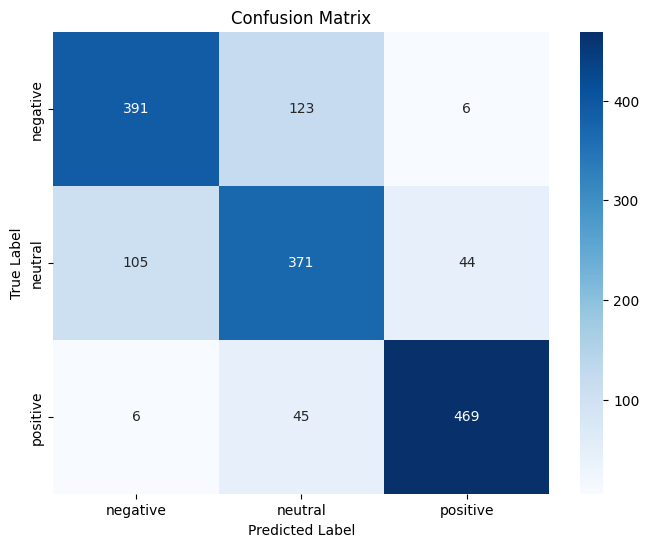

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(y_true, preds)

# Get class labels from LabelEncoder (e.g., ["negative", "neutral", "positive"])
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the Final Model and Tokenizer
save_directory = "/content/drive/MyDrive/bert622/final_model"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to /content/drive/MyDrive/bert622/final_model
